# An automated approach to crystal detection using machine learning techniques

Malcolm Ramsay

@malramsay64

github.com/malramsay64

## Follow Along

[demo.malramsay.com](demo.malramsay.com)

- Shift + Enter to run code
- Run all cells from the top

All code and more available at

[github.com/malramsay64/MLCrystals](github.com/malramsay64/MLCrystals)

## Outline

### Machine Learning

- What is it?
- Where is it useful?
- How can I use it?

# Automated Cyrstal Detection

- Clustering

### What is Machine Learning

- Technique for drawing a line
- Complicated methods draw complicated lines
- Challenge is drawing a line which doesn't overfit the data

#### Curve Fitting example

A simple example of using machine learning for fitting a straight line to a sequence of points.

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

num_items = 100

In [2]:
np.random.seed(0)
X = np.arange(num_items) + np.random.normal(scale=10, size=num_items)
lr = LinearRegression()
y = np.arange(num_items)
X_r = lr.fit(X.reshape(-1, 1), y).predict(y.reshape(-1,1))

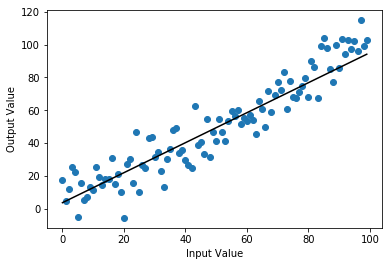

In [3]:
fig, ax = plt.subplots()
ax.scatter(y, X)
ax.plot(y, X_r, c='k')
ax.set_xlabel("Input Value")
ax.set_ylabel("Output Value");

In [4]:
fig.savefig('figures/drawing_lines_regression.png')

#### Classification Example

This is a simple example of using machine learning to separate two groups of points.
Finding the line which best separates the two groups.

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Output the figures to notebook
%matplotlib inline

# Number of random points to generate
num_items = 100

In [6]:
# Create two normally distributed datasets of random numbers
# Set random seed for reproducibility
np.random.seed(0)
# X_0 distributed around (-1, -1)
X_0 = np.random.normal(loc=-1, scale=1.0, size=(num_items, 2))
# X_1 distributed around (1, 1)
X_1 = np.random.normal(loc=1, scale=1.0, size=(num_items, 2))

# Create single dataset with both sets of values
X = np.concatenate([X_0, X_1])
# These are the groups X_0, or X_1 each point belongs to
y = np.array([0]*num_items + [1]*num_items)

# Draw a linear line to separate the two groups
lda = LinearDiscriminantAnalysis()
lda.fit(X, y);

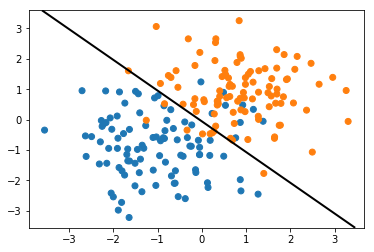

In [7]:
# Plot each of the randomly generated points
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', norm=colors.Normalize(0, 10))

# Find the line separating the two classes by testing a grid of points
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_items),
                     np.linspace(y_min, y_max, num_items))

Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
# Plot the learned contour separating the two groups
ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='k');

In [8]:
fig.savefig('figures/drawing_lines_classification.png', dpi=300)

### Where is Machine Learning Useful

- Classification into known groups 
- Datasets with high dimensionality
- Hard to (computationally) define tasks

### How to get started

- this talk
- [kaggle.com/learn](kaggle.com/learn)
- scikit-learn

## Machine Learning for Classification

- Labelled dataset, known structure of each molecule
- Break into training (80%) and test (20%) datasets
- Develop model on training dataset
- Score on test dataset

### Trimer Model

- 2D rigid molecules

In [9]:
# Import nessecary packages

from sdanalysis.figures import plot_frame
import sdanalysis

# Import project source files
import sys
sys.path.append("../src")
import trimer

# Set bokeh to output configurations to the notebook
from bokeh.io import show, output_notebook, export_png
from bokeh.models import Range1d 
output_notebook()

Loading BokehJS ...

#### Load dataset

This loads all the configurations into a dataset.

In [10]:
crystals = ["p2", "p2gg", "pg"]
temperatures = [0.40, 0.44, 0.46, 0.50]
snaps = trimer.read_files(
    index=0,
    temperature=temperatures,
    pressure=1.00,
    crystals=crystals,
)

#### What does it look like

- Orientations denoted with colour

In [11]:
plot = plot_frame(snaps[0])
# Zoom in on the interface of the liquid and crystal
plot.x_range=Range1d(-80, -40)
plot.y_range=Range1d(-20, 20)
show(plot)

In [12]:
export_png(plot, 'figures/Trimer_snapshot.png')

'/Users/malcolm/Projects/MLCrystals/talks/figures/Trimer_snapshot.png'

### Features

- Most important part of machine learning
- What distinguises the liquid from the cyrstal
- Domain expertise is important

#### Trimer Features

- Relative orientation of nearest neighbours
- Invariant of crystal orientation

<img src="figures/orientations.png" alt="Relative Orientations" style="width: 60%;"/>

### Using a Model

- A trained model is simple to store and use with new data
- No different to any other order parameter
- Best practice is to make dataset and code to available to recreate model

#### Trimer Model

In [13]:
# Find labels based on location within the simulation cell
classes = np.concatenate(
    [trimer.classify_mols(snap, crys) for snap, crys in zip(snaps, crystals*len(temperatures))]
)
# Calculate the features for classification
orientations = np.concatenate(
    [sdanalysis.order.relative_orientations(s.box, s.position, s.orientation) for s in snaps]
)
# Ignore particles on the interface for simplicity
mask = classes < 4
X = orientations[mask]
y = classes[mask]

In [14]:
from sklearn import model_selection

# 20% of the dataset is for validation
validation_size = 0.20
seed = 7
# Split dataset into training and validation sets
selected = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
X_train, X_validation, y_train, y_validation = selected

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Train algorithm using training dataset
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Save model to a file which can be recalled later
from sklearn.externals import joblib
joblib.dump(knn, '../models/knn-trimer.pkl');
# knn = joblib.load('../models/knn-trimer.pkl')

In [16]:
# Calculate accuracy using validation dataset
predictions = knn.predict(X_validation)
print(f"Accuracy: {np.mean(predictions == y_validation):.1%}")

Accuracy: 96.2%


## Clustering

- How do I label 1000s of molecules?
- How do I know what structure is important?
- Which structures keep appearing?

### Clustering Trimer

- Results and code go here



In [17]:
# Calculate features for clustering
orientations = np.concatenate(
    [sdanalysis.order.relative_orientations(s.box, s.position, s.orientation) for s in snaps]
)
X_clust = orientations

In [18]:
from sklearn import cluster
# Cluster the samples plotting a representative crystal of each
dbscan = cluster.DBSCAN(min_samples=400, eps=0.9)
fig = trimer.plot_clustering(dbscan, X_clust, snaps)
show(fig)

In [19]:
cluster_assignment = np.split(dbscan.fit_predict(X_clust), len(snaps))
for clust, snap, crys in zip(cluster_assignment, snaps, crystals):
    frame = plot_frame(snap, order_list=clust, categorical_colour=True)
    frame.axis.visible = False
    frame.xgrid.visible=False
    frame.ygrid.visible=False
    frame.toolbar_location = None
    frame.toolbar.logo=None
    export_png(frame, f'figures/clustering_results_{crys}.png')

### What now?

- Clusters are labelled training data
- Form the basis for a new model for identification in further

In [20]:
from sklearn.neighbors import KNeighborsClassifier
# Create clasifier to train on clustered dataset
knn_clust = KNeighborsClassifier()
knn_clust.fit(X_clust, dbscan.fit_predict(X_clust));

## Conclusion

- Features are the most imporatand part of machine learning
- Clustering can identify strucutre within a configuration
- Clusters as training datasets allow for developing a model

## How Can I get Involved?

- Make datasets available (zenodo or similar)
- Check out the project page github.com/malramsay64/MLCrystals
- Try it out yourself